<a href="https://colab.research.google.com/github/BonfaDScience/BonfaDScience/blob/main/Recomendacao_por_similaridade_de_imagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#hide
#{"username":"<your kaggle username>","key":"<your kaggle api key>"}
%%writefile kaggle.json
{"username":"<your kaggle username>","key":"<your kaggle api key>"}

Writing kaggle.json


In [3]:
#hide
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=d39ab6a7a853fa8a65df46b189d40cc0809394c6cbd812c69cfe8cdd7961b1de
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [ ]:
#hide-output
# downloading raw images from kaggle
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

In [5]:
import pandas as pd
from shutil import move
import os
from tqdm import tqdm

os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/images/')
co = 0
os.mkdir('/content/Fashion_data/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

100%|██████████| 44441/44441 [02:24<00:00, 307.09it/s]

Moved 44441 images.


In [ ]:
!pip install --upgrade tensorflow tensorflow-hub

In [6]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.18.0
Hub version: 0.16.1
GPU is NOT AVAILABLE


In [10]:
#MODULE_HANDLE = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5"  # Exemplo
MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
IMAGE_SIZE = (224, 224)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 32
N_FEATURES = 256
# Testar se o modelo carrega corretamente
hub_layer = hub.KerasLayer(MODULE_HANDLE, trainable=False)
print("Modelo carregado com sucesso!")

Using https://tfhub.dev/google/bit/m-r50x3/1 with input size (224, 224)
Modelo carregado com sucesso!


In [8]:
#hide
data_dir = '/content/Fashion_data/categories'

In [9]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 8886 images belonging to 7 classes.
Found 35555 images belonging to 7 classes.


In [17]:
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
import numpy as np
import os

# Função para extrair características
def extract_features(image_path):
    # Carregar e pré-processar a imagem
    def load_and_preprocess_image(image_path):
        try:
            img = Image.open(image_path).resize((224, 224))
            img_array = np.array(img) / 255.0
            img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
            img_tensor = tf.expand_dims(img_tensor, axis=0)  # Adiciona dimensão de lote
            return img_tensor
        except Exception as e:
            print(f"Erro ao processar a imagem {image_path}: {e}")
            return None

    image_tensor = load_and_preprocess_image(image_path)

    if image_tensor is not None:
        # Executar o modelo BiT para extrair características
        features = hub_layer(image_tensor)
        return features.numpy()
    else:
        return None  # Retorna None se a imagem não puder ser processada

# # Caminho para a imagem
image_path = "/content/Fashion_data/categories/Footwear/10035.jpg" # Substitua pelo caminho da sua imagem

# Extrair características
features = extract_features(image_path)

# Exibir as características extraídas
if features is not None:
    print(features)
else:
    print("Não foi possível extrair características da imagem.")


[[0.9255485  5.0760894  0.3537263  ... 0.49991593 0.37472543 0.20298086]]


/////////////////////////////

/content/Fashion_data/categories/Footwear

////////////////////////////

In [ ]:
# DEU RUIM COM O MODELO BiT
# import tensorflow as tf
# import tensorflow_hub as hub
# from PIL import Image
# import numpy as np
# import os

# # Carregar o modelo BiT do TensorFlow Hub
# MODULE_HANDLE = "https://tfhub.dev/google/bit/m-r50x3/1"

# # Criar camada Hub
# hub_layer = hub.KerasLayer(MODULE_HANDLE, trainable=False)

# # Função para carregar e pré-processar a imagem
# def load_and_preprocess_image(image_path):
#     try:
#         img = Image.open(image_path).convert("RGB").resize((224, 224)) # Converter para RGB
#         img_array = np.array(img) / 255.0
#         img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
#         img_tensor = tf.expand_dims(img_tensor, axis=0)  # Adiciona dimensão de lote
#         return img_tensor
#     except Exception as e:
#         print(f"Erro ao carregar/pré-processar {image_path}: {e}")
#         return None

# # Função para extrair características
# def extract_features(image_path, hub_layer):
#     img_tensor = load_and_preprocess_image(image_path)
#     if img_tensor is None:
#         return None

#     try:
#         features = hub_layer(img_tensor)
#         return features.numpy()
#     except Exception as e:
#         print(f"Erro no modelo BiT ao processar {image_path}: {e}")
#         return None

# # Caminho para a pasta de imagens
# image_folder = "/content/Fashion_data/categories/Footwear" # Substitua pelo caminho da sua pasta de imagens

# # Listar caminhos de imagem
# image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if filename.lower().endswith(('.png', '.jpg', '.jpeg'))]

# # Dicionário para armazenar características
# features_dict = {}

# # Iterar sobre imagens
# for image_path in image_paths:
#     features = extract_features(image_path, hub_layer)
#     if features is not None:
#         features_dict[image_path] = features
#     else:
#         print(f"Não foi possível extrair características da imagem: {image_path}")

# # Exibir características extraídas
# for image_path, features in features_dict.items():
#     print(f"Características da imagem {image_path}: {features}")

implementando o sistema de recomendação

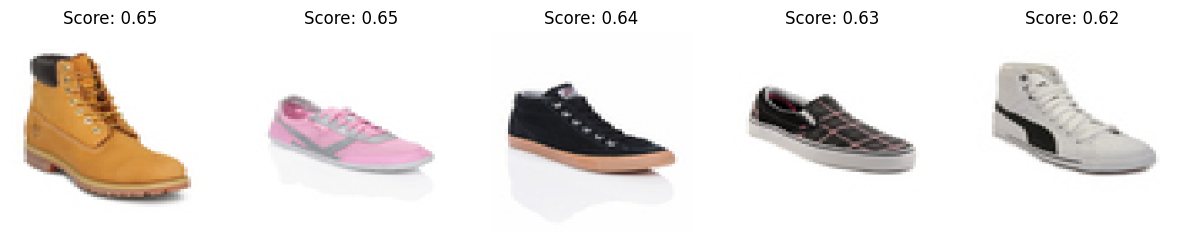

In [38]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import os

# 1. Carregar o modelo MobileNetV2 pré-treinado do TensorFlow Hub
module_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4"
module = hub.KerasLayer(module_handle)

# 2. Função para extrair características de uma imagem
def extract_features(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    features = model(img_array)
    return features.numpy().flatten()

# 3. Caminho para a imagem de consulta
query_image_path = "/content/NIKE+DUNK+LOW+RETRO+SE2.jpg"  # Substitua pelo caminho da sua imagem

# Extrair características da imagem de consulta
query_features = extract_features(query_image_path, module)

# 4. Caminho para o diretório com as imagens do dataset
dataset_dir = "/content/Fashion_data/categories/Footwear"  # Substitua pelo caminho do seu diretório

# Obter a lista de caminhos de todas as imagens no diretório
image_paths = [os.path.join(dataset_dir, filename) for filename in os.listdir(dataset_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))]

# Extrair características de todas as imagens do dataset
image_features = [extract_features(path, module) for path in image_paths]

# 5. Calcular similaridade entre a imagem de consulta e as imagens do dataset
similarities = cosine_similarity([query_features], image_features)[0]

# 6. Obter os 5 maiores scores de similaridade e seus índices
top_5_indices = np.argsort(similarities)[-5:][::-1]
top_5_scores = similarities[top_5_indices]

# 7. Exibir as 5 imagens mais similares e seus scores
plt.figure(figsize=(15, 5))
for i, index in enumerate(top_5_indices):
    plt.subplot(1, 5, i + 1)
    img = image.load_img(image_paths[index], target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"Score: {top_5_scores[i]:.2f}")
    plt.axis('off')
plt.show()